In [20]:
import sys
sys.path.append('../')

from models.SSA import SSA
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import seaborn as sns
import optuna
from optuna.visualization import plot_optimization_history, plot_contour

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.neural_network import MLPRegressor
from os import path

import pmdarima as pm


from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings

warnings.filterwarnings("ignore")

PATH = r'C:\Users\Никита\SSA\data'

plt.style.use('seaborn-v0_8-whitegrid')

## Дополнительный функционал

In [21]:
def make_ts_set(ts,dim):
    x = np.vstack([ts[i:dim+i] for i in range(len(ts)-dim)])
    y = ts[dim:]
    return x,y


def validate_model(model, ts_train, ts_test ,M, dim):

    # fitting
    x_train, y_train = make_ts_set(ts_train, dim = dim)
    ts_val = np.concatenate([ts_train[-dim:], ts_test])
    x_test, y_test = make_ts_set(ts_val, dim = dim)

    model_list = []
    model.fit(x_train, y_train)

    # predicting
    predictions = []
    ts_new = ts.copy()
    for i in range(M):
        prediction = model.predict(ts_new[-M-dim+i:-M+i].reshape(1,-1))
        ts_new[-M+i] = prediction

        predictions.append(prediction)

    # evaluating
    r2 = r2_score(ts_test, predictions)
    mape = mean_absolute_percentage_error(ts_test, predictions)
    mse = mean_squared_error(ts_test, predictions)

    return r2, mape, mse, np.array(predictions)

def moving_mape(y_true, predictions):
    if len(y_true) != len(predictions):
        raise ValueError('Shape mismatch')
    moving_metric = [mean_absolute_percentage_error(y_true[:i], predictions[:i]) for i in range(1,len(predictions))]

    return np.array(moving_metric)

def moving_average(x, l):
    reduction = (l-1)//2
    moving_average = np.convolve(x, np.ones(l) / l, 'valid')

    left_tail = np.cumsum(x[:reduction]) / np.cumsum(np.ones((reduction,)))
    right_tail = np.cumsum(x[-reduction:]) / np.cumsum(np.ones((reduction,)))

    return np.concatenate([left_tail, moving_average, right_tail])

# Beer production

In [22]:
ts = pd.read_csv(path.join(PATH, 'beer_production.csv'))['Monthly beer production'].to_numpy()

M = 50 
ts_train, ts_test = ts[:-M], ts[-M:]

#model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)

0.17171595605051068


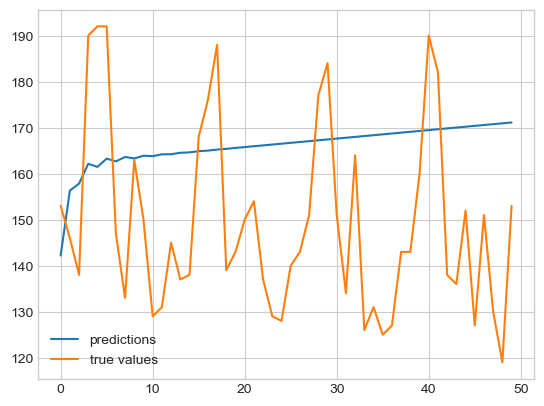

In [24]:
# предсказания ARIMA, почему решил отказаться
model = pm.auto_arima(ts_train, seasonal = True, )
predictions = model.predict(50)
plt.plot(predictions, label = 'predictions')
plt.plot(ts_test, label = 'true values')
plt.legend()
print(mean_absolute_percentage_error(ts_test, predictions))

In [6]:
# benchmark

mean = np.zeros_like(ts_test) + ts_train.mean()
print('MAPE', mean_absolute_percentage_error(ts_test, mean))

MAPE 0.10911289633219017


In [7]:
scores = []
for _ in range(5):
    model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
    _, mape, _, _ = validate_model(model, ts_train, ts_test, M, dim=10)
    scores.append(mape)

print('MAPE:', np.array(scores).mean())

MAPE: 0.2237279920583209


### 1. Moving average

In [30]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,213)
    dim = trial.suggest_int('dim', 3,100)

    smoothed_ts = moving_average(ts_train, l)

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        mape_scores.append(mape)
        r2_scores.append(r2)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [31]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('moving_average_study.csv')

[I 2024-05-10 16:35:32,466] A new study created in memory with name: no-name-fde93312-c4fa-4788-8666-856ec16609bd


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-10 16:35:34,555] Trial 0 finished with values: [-1.3494960584980837, 0.18642062298440276] and parameters: {'window_length': 51, 'dim': 31}. 
[I 2024-05-10 16:35:37,337] Trial 1 finished with values: [-1.2493603710140888, 0.1818023347057529] and parameters: {'window_length': 35, 'dim': 63}. 
[I 2024-05-10 16:35:38,487] Trial 2 finished with values: [-1.4748373144227807, 0.178774201134914] and parameters: {'window_length': 74, 'dim': 22}. 
[I 2024-05-10 16:35:41,170] Trial 3 finished with values: [-0.7122580329065646, 0.14351439025225798] and parameters: {'window_length': 72, 'dim': 11}. 
[I 2024-05-10 16:35:42,155] Trial 4 finished with values: [-0.36006559375274894, 0.13480092306374067] and parameters: {'window_length': 116, 'dim': 15}. 
[I 2024-05-10 16:35:46,129] Trial 5 finished with values: [-2.161140664980043, 0.20503819039130916] and parameters: {'window_length': 35, 'dim': 55}. 
[I 2024-05-10 16:35:47,140] Trial 6 finished with values: [-0.2758272146456641, 0.11043234

In [32]:
study.best_trials

[FrozenTrial(number=168, state=TrialState.COMPLETE, values=[-0.16740777734654028, 0.10178269080182796], datetime_start=datetime.datetime(2024, 5, 10, 16, 47, 53, 151707), datetime_complete=datetime.datetime(2024, 5, 10, 16, 47, 57, 574524), params={'window_length': 72, 'dim': 5}, user_attrs={}, system_attrs={'nsga2:generation': 3}, intermediate_values={}, distributions={'window_length': IntDistribution(high=213, log=False, low=3, step=1), 'dim': IntDistribution(high=100, log=False, low=3, step=1)}, trial_id=168, value=None),
 FrozenTrial(number=304, state=TrialState.COMPLETE, values=[-0.1785851569504354, 0.10136700691104758], datetime_start=datetime.datetime(2024, 5, 10, 16, 56, 53, 953150), datetime_complete=datetime.datetime(2024, 5, 10, 16, 56, 55, 453227), params={'window_length': 164, 'dim': 3}, user_attrs={}, system_attrs={'nsga2:generation': 6}, intermediate_values={}, distributions={'window_length': IntDistribution(high=213, log=False, low=3, step=1), 'dim': IntDistribution(hig

In [33]:
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
smoothed_ts = moving_average(ts_train, l = 3)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=56)

R2: 0.3378785035694245
MAPE: 0.09645117334373769
MSE: 268.270707314382


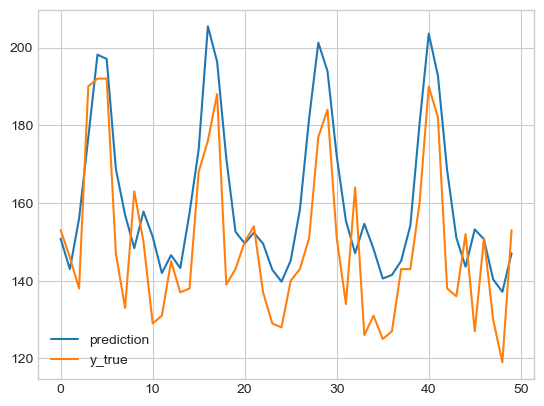

In [34]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('moving_average_predictions.png', dpi = 300);

### 2. SSA 

In [5]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,213)
    rank = trial.suggest_int('rank', 1, l)
    dim = trial.suggest_int('dim', 3,100)

    ssa = SSA(l = l, rank = rank)
    smoothed_ts, _ = ssa.transform_to_series(ts_train)
    smoothed_ts = smoothed_ts.sum(0)

    mape_scores = []
    r2_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [ ]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('SSA_study.csv')

In [8]:
study.best_trials

[FrozenTrial(number=450, state=TrialState.COMPLETE, values=[0.7005347790245384, 0.055433334571700965], datetime_start=datetime.datetime(2024, 5, 10, 18, 56, 47, 611587), datetime_complete=datetime.datetime(2024, 5, 10, 18, 56, 55, 463579), params={'window_length': 58, 'rank': 26, 'dim': 35}, user_attrs={}, system_attrs={'nsga2:generation': 9}, intermediate_values={}, distributions={'window_length': IntDistribution(high=213, log=False, low=3, step=1), 'rank': IntDistribution(high=58, log=False, low=1, step=1), 'dim': IntDistribution(high=100, log=False, low=3, step=1)}, trial_id=450, value=None)]

In [9]:
ssa = SSA(l = 58, rank = 26)
smoothed_ts, _ = ssa.transform_to_series(ts_train)
smoothed_ts = smoothed_ts.sum(0)

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=35)

R2: 0.6295039595443681
MAPE: 0.0674053760571867
MSE: 150.1132879177436


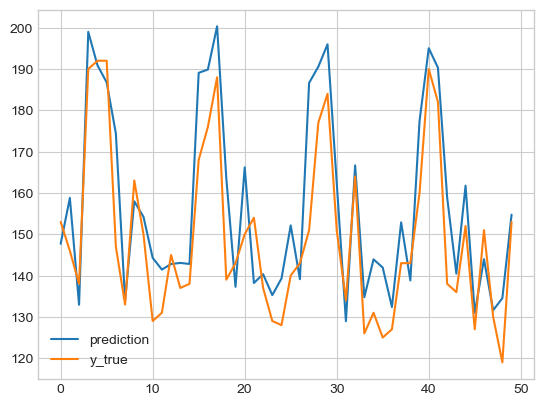

In [10]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('ssa_predictions.png', dpi = 300);

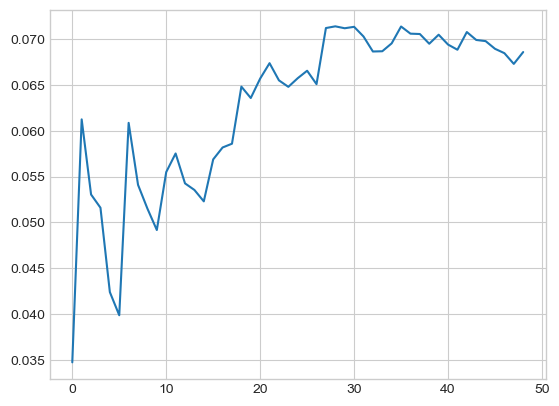

In [11]:
sns.lineplot(x = np.arange(M-1),y =  moving_mape(ts_test, predictions[:,0]));

### 3. Exponential smoothing

In [4]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    dim = trial.suggest_int('dim', 3,100)

    smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [ ]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('Exp_smoothing_study.csv')

In [6]:
study.best_trials[0].params

{'smoothing_level': 0.9250668686470647, 'dim': 61}

In [7]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=61)

R2: 0.6030193637808257
MAPE: 0.0748051407659887
MSE: 160.84400920790492


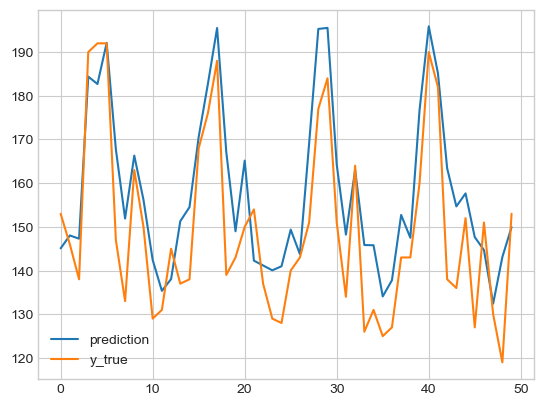

In [24]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('exp_smoothing_predictions.png', dpi = 300);

### 4. Holt-Winters model

In [9]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    smoothing_trend = trial.suggest_float('smoothing_trend', 0,1)
    # seasonal_periods = trial.suggest_categorical('seasonal_periods', [2,4,6,7,12,30])
    # seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', 'additive', 'multiplicative', None])
    use_boxcox = trial.suggest_categorical('use_boxcox', [True, False])
    dim = trial.suggest_int('dim', 3,100)

    smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = use_boxcox).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [10]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('HoltWinters_study.csv')

[I 2024-05-16 08:16:52,500] A new study created in memory with name: no-name-b00e0402-c410-4c8d-ace1-e0da065b16e8


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-16 08:16:55,685] Trial 0 finished with values: [0.29132285765330745, 0.10007669202051543] and parameters: {'smoothing_level': 0.7142018300296177, 'smoothing_trend': 0.6895785432889812, 'use_boxcox': False, 'dim': 89}. 
[I 2024-05-16 08:16:59,219] Trial 1 finished with values: [0.2987510366389168, 0.09677096086741405] and parameters: {'smoothing_level': 0.6895489805070489, 'smoothing_trend': 0.9483548979403488, 'use_boxcox': False, 'dim': 52}. 
[I 2024-05-16 08:17:00,902] Trial 2 finished with values: [-15.246899316395409, 0.2737954826632133] and parameters: {'smoothing_level': 0.5308368543969153, 'smoothing_trend': 0.709689926186269, 'use_boxcox': False, 'dim': 18}. 
[I 2024-05-16 08:17:02,049] Trial 3 finished with values: [-1.834453279757593, 0.19774145069591476] and parameters: {'smoothing_level': 0.4721314464817692, 'smoothing_trend': 0.25378636556175316, 'use_boxcox': False, 'dim': 31}. 
[I 2024-05-16 08:17:03,715] Trial 4 finished with values: [-0.7822225783920228, 0.1

In [11]:
study.best_trials[0]

FrozenTrial(number=141, state=TrialState.COMPLETE, values=[0.6536201878940778, 0.0663048565900605], datetime_start=datetime.datetime(2024, 5, 16, 8, 23, 25, 390182), datetime_complete=datetime.datetime(2024, 5, 16, 8, 23, 29, 627093), params={'smoothing_level': 0.8963994392275162, 'smoothing_trend': 0.4218919131144234, 'use_boxcox': False, 'dim': 52}, user_attrs={}, system_attrs={'nsga2:generation': 2}, intermediate_values={}, distributions={'smoothing_level': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'smoothing_trend': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'use_boxcox': CategoricalDistribution(choices=(True, False)), 'dim': IntDistribution(high=100, log=False, low=3, step=1)}, trial_id=141, value=None)

In [12]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothing_trend = study.best_trials[0].params['smoothing_trend']

smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, 52)

In [27]:
smoothing_level = 0.8963994392275162
smoothing_trend = 0.4218919131144234

smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, 52)

R2: 0.31045992463290717
MAPE: 0.10023689964452843
MSE: 279.3798490723644


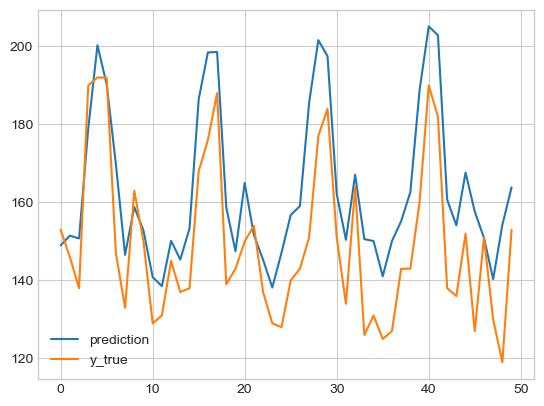

In [28]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('holts_predictions.png', dpi = 300);

# High frequency trading data

In [6]:
ts = pd.read_csv(path.join(PATH, 'hft_data.csv'))['price'].to_numpy()[:8000]

M = 50 
ts_train, ts_test = ts[:-M], ts[-M:]

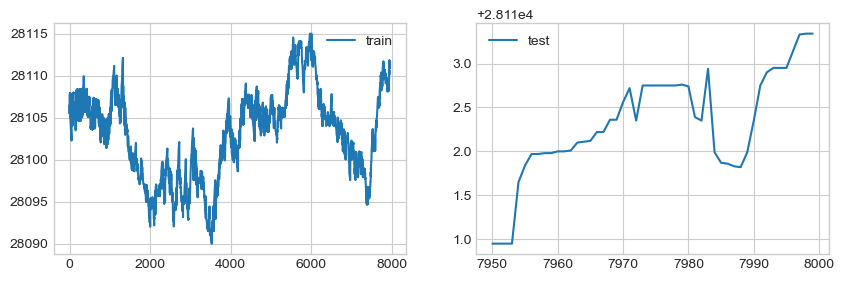

In [13]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.lineplot(x = np.arange(len(ts_train)), y = ts_train, ax = ax[0], label = 'train')
sns.lineplot(x = np.arange(len(ts_train), len(ts_train)+M), y = ts_test, ax = ax[1], label = 'test')
plt.legend();

## 1. Moving average

In [21]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,213)
    dim = trial.suggest_int('dim', 3,100)

    smoothed_ts = moving_average(ts_train, l)

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        mape_scores.append(mape)
        r2_scores.append(r2)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [22]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('moving_average_study2.csv')

[I 2024-05-16 12:30:02,997] A new study created in memory with name: no-name-53f7c894-c5dc-433e-890a-9f454252eb3f


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-16 12:30:05,258] Trial 0 finished with values: [-21.439081212789482, 9.479624306283886e-05] and parameters: {'window_length': 27, 'dim': 64}. 
[I 2024-05-16 12:30:07,529] Trial 1 finished with values: [-28.064626488075703, 0.00010726813859841052] and parameters: {'window_length': 213, 'dim': 76}. 
[I 2024-05-16 12:30:09,778] Trial 2 finished with values: [-19.327803964264042, 9.090079577031359e-05] and parameters: {'window_length': 109, 'dim': 52}. 
[I 2024-05-16 12:30:12,122] Trial 3 finished with values: [-1091.2336383254165, 0.0003812155356488319] and parameters: {'window_length': 143, 'dim': 76}. 
[I 2024-05-16 12:30:14,509] Trial 4 finished with values: [-6.8646172942914685, 5.607124943448951e-05] and parameters: {'window_length': 52, 'dim': 29}. 
[I 2024-05-16 12:30:17,215] Trial 5 finished with values: [-19.794867768788784, 8.684145324508513e-05] and parameters: {'window_length': 175, 'dim': 60}. 
[I 2024-05-16 12:30:19,727] Trial 6 finished with values: [-9.277151329

In [23]:
study.best_trials

[FrozenTrial(number=780, state=TrialState.COMPLETE, values=[-2.888489548040448, 3.6522952795097865e-05], datetime_start=datetime.datetime(2024, 5, 16, 13, 0, 33, 140798), datetime_complete=datetime.datetime(2024, 5, 16, 13, 0, 35, 352682), params={'window_length': 19, 'dim': 8}, user_attrs={}, system_attrs={'nsga2:generation': 15}, intermediate_values={}, distributions={'window_length': IntDistribution(high=213, log=False, low=3, step=1), 'dim': IntDistribution(high=100, log=False, low=3, step=1)}, trial_id=780, value=None)]

In [30]:
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
smoothed_ts = moving_average(ts_train, l = 19)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=8)

R2: -4.412819266977699
MAPE: 4.531048363569521e-05
MSE: 1.9278089249002073


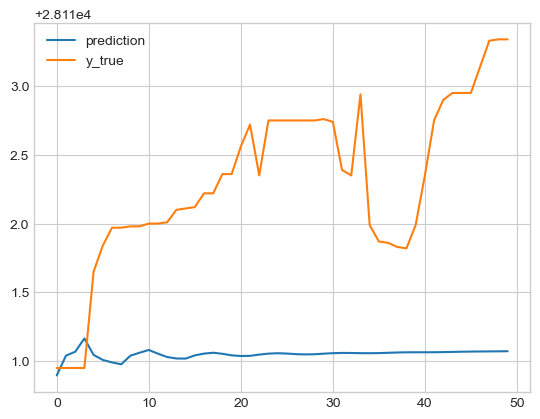

In [31]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('moving_average_predictions2.png', dpi = 300);

## 2. SSA

In [33]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,200)
    rank = trial.suggest_int('rank', 1, l)
    dim = trial.suggest_int('dim', 3,1000)

    ssa = SSA(l = l, rank = rank)
    smoothed_ts, _ = ssa.transform_to_series(ts_train)
    smoothed_ts = smoothed_ts.sum(0)

    mape_scores = []
    r2_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [34]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('SSA_study2.csv')

[I 2024-05-16 13:14:03,392] A new study created in memory with name: no-name-f876e91f-04b2-4e0b-90bf-e6845d350721


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-16 13:14:17,215] Trial 0 finished with values: [-310.07327829098654, 0.0003394170643103365] and parameters: {'window_length': 95, 'rank': 66, 'dim': 794}. 
[I 2024-05-16 13:14:31,512] Trial 1 finished with values: [-1340.6123154806612, 0.000537078160373122] and parameters: {'window_length': 168, 'rank': 51, 'dim': 775}. 
[I 2024-05-16 13:14:43,887] Trial 2 finished with values: [-387.4394391802524, 0.0003738377821753137] and parameters: {'window_length': 81, 'rank': 18, 'dim': 705}. 
[I 2024-05-16 13:14:54,879] Trial 3 finished with values: [-5.845168935170693, 5.026537339004919e-05] and parameters: {'window_length': 111, 'rank': 59, 'dim': 21}. 
[I 2024-05-16 13:14:58,480] Trial 4 finished with values: [-9.010187879273825, 5.8886878018073555e-05] and parameters: {'window_length': 104, 'rank': 15, 'dim': 23}. 
[I 2024-05-16 13:15:04,510] Trial 5 finished with values: [-20.811341707810378, 8.923305522227423e-05] and parameters: {'window_length': 83, 'rank': 18, 'dim': 191}. 


In [37]:
study.best_trials[0].params

{'window_length': 77, 'rank': 9, 'dim': 6}

In [54]:
ssa = SSA(l = 77, rank = 9)
smoothed_ts, _ = ssa.transform_to_series(ts_train)
smoothed_ts = smoothed_ts.sum(0)

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=6)

R2: -3.192781242948694
MAPE: 3.978322614537332e-05
MSE: 1.4932848672081809


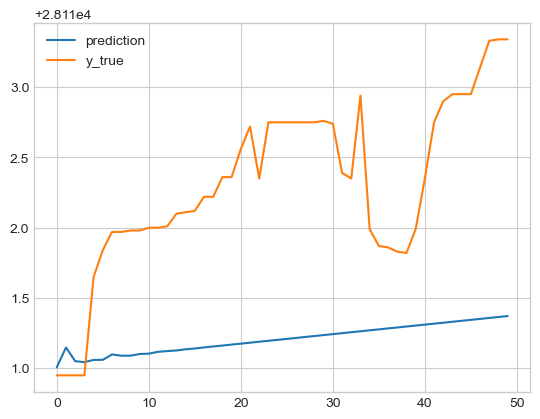

In [55]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('ssa_predictions2.png', dpi = 300);

## 3. Exponential smooting

In [56]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    dim = trial.suggest_int('dim', 3,1000)

    smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [57]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('Exp_smoothing_study2.csv')

[I 2024-05-16 15:47:59,071] A new study created in memory with name: no-name-24e576ef-50f4-4f26-9382-a9b95c645770


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-16 15:48:02,093] Trial 0 finished with values: [-19.445976747781177, 9.201960114276746e-05] and parameters: {'smoothing_level': 0.5206441973802353, 'dim': 256}. 
[I 2024-05-16 15:48:08,005] Trial 1 finished with values: [-185020.98763178734, 0.004605924980020797] and parameters: {'smoothing_level': 0.5168043844995462, 'dim': 845}. 
[I 2024-05-16 15:48:12,633] Trial 2 finished with values: [-163.94385812189083, 0.0002557872116612164] and parameters: {'smoothing_level': 0.041884353688691145, 'dim': 577}. 
[I 2024-05-16 15:48:16,388] Trial 3 finished with values: [-12883.257769929758, 0.0013342431889962329] and parameters: {'smoothing_level': 0.01041347297900952, 'dim': 617}. 
[I 2024-05-16 15:48:20,970] Trial 4 finished with values: [-340729.34596597584, 0.00568165889704794] and parameters: {'smoothing_level': 0.5612538624200423, 'dim': 505}. 
[I 2024-05-16 15:48:24,029] Trial 5 finished with values: [-22.277106803815943, 9.253765127772213e-05] and parameters: {'smoothing_leve

In [58]:
study.best_trials[0].params

{'smoothing_level': 0.8834974443927411, 'dim': 10}

In [59]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=10)

R2: -3.8924448966317
MAPE: 4.2842580686393685e-05
MSE: 1.7424743873954145


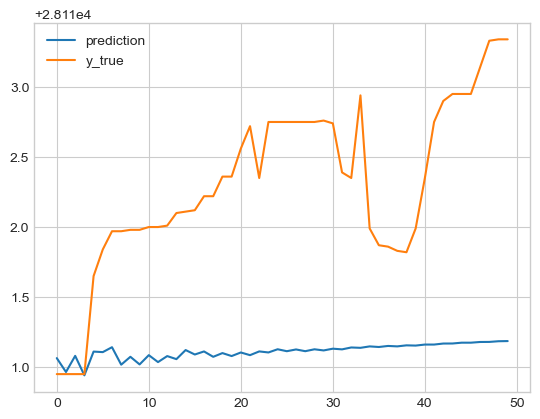

In [60]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('exp_smoothed_predictions2.png', dpi = 300);

## 4. Holt's model

In [20]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    smoothing_trend = trial.suggest_float('smoothing_trend', 0,1)
    # seasonal_periods = trial.suggest_categorical('seasonal_periods', [2,4,6,7,12,30])
    # seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', 'additive', 'multiplicative', None])
    #use_boxcox = trial.suggest_categorical('use_boxcox', [True, False])
    dim = trial.suggest_int('dim', 3,1000)

    smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [21]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('HoltWinters_study2.csv')

[I 2024-05-18 07:54:56,556] A new study created in memory with name: no-name-3d973c0a-2968-4024-b53e-7855bc40ba01


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-18 07:55:04,356] Trial 0 finished with values: [-7889.786104940945, 0.0009895493930220103] and parameters: {'smoothing_level': 0.05538552845503075, 'smoothing_trend': 0.981867257860193, 'dim': 384}. 
[I 2024-05-18 07:55:11,618] Trial 1 finished with values: [-24.00966656943761, 0.00010181916016455624] and parameters: {'smoothing_level': 0.9363804098305659, 'smoothing_trend': 0.2914112337752811, 'dim': 105}. 
[I 2024-05-18 07:55:24,997] Trial 2 finished with values: [-1214698.7607165638, 0.01144505880349296] and parameters: {'smoothing_level': 0.22979142893814486, 'smoothing_trend': 0.8143120923796306, 'dim': 737}. 
[I 2024-05-18 07:55:39,490] Trial 3 finished with values: [-47270.806796539735, 0.002797842219810617] and parameters: {'smoothing_level': 0.112233588569572, 'smoothing_trend': 0.33516151903039837, 'dim': 971}. 
[I 2024-05-18 07:55:51,710] Trial 4 finished with values: [-172.32908511269784, 0.0002504715091477611] and parameters: {'smoothing_level': 0.70045974715199

In [24]:
study.best_trials[0].params

{'smoothing_level': 0.35719901400023213,
 'smoothing_trend': 0.9378857949419868,
 'dim': 11}

In [25]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothing_trend = study.best_trials[0].params['smoothing_trend']

smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, 11)

R2: -2.597646557755157
MAPE: 3.6543033429173416e-05
MSE: 1.281323983046906


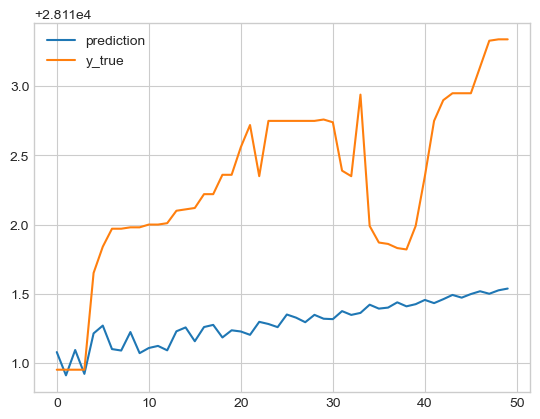

In [27]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('holts_predictions2.png', dpi = 300);

# Earthquake data

In [3]:
ts = pd.read_csv(path.join(PATH, 'earthquakes.csv'))['____up(m)'].to_numpy()[:8000]

M = 50 
ts_train, ts_test = ts[:-M], ts[-M:]

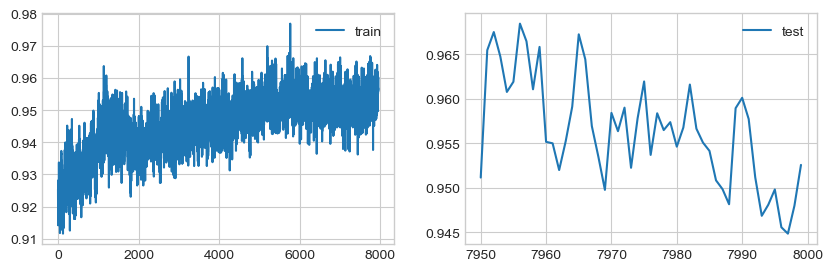

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,3))

sns.lineplot(x = np.arange(len(ts_train)), y = ts_train, ax = ax[0], label = 'train')
sns.lineplot(x = np.arange(len(ts_train), len(ts_train)+M), y = ts_test, ax = ax[1], label = 'test')
plt.legend();

## 1. Moving average

In [34]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,213)
    dim = trial.suggest_int('dim', 3,100)

    smoothed_ts = moving_average(ts_train, l)

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        mape_scores.append(mape)
        r2_scores.append(r2)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [35]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('moving_average_study3.csv')

[I 2024-05-18 10:48:26,155] A new study created in memory with name: no-name-4e020c62-67b3-4fb9-861e-23a17b388e96


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-18 10:48:27,515] Trial 0 finished with values: [-2.0114421836893768, 0.008814461643236305] and parameters: {'window_length': 23, 'dim': 10}. 
[I 2024-05-18 10:48:28,777] Trial 1 finished with values: [-1.8421627829196914, 0.008554629273570206] and parameters: {'window_length': 142, 'dim': 23}. 
[I 2024-05-18 10:48:30,227] Trial 2 finished with values: [-2.143438003220623, 0.00897415189942877] and parameters: {'window_length': 122, 'dim': 89}. 
[I 2024-05-18 10:48:31,681] Trial 3 finished with values: [-3.4308912603463497, 0.009908688018958695] and parameters: {'window_length': 100, 'dim': 44}. 
[I 2024-05-18 10:48:33,194] Trial 4 finished with values: [-1.4034017336538493, 0.008130111079998554] and parameters: {'window_length': 62, 'dim': 36}. 
[I 2024-05-18 10:48:34,624] Trial 5 finished with values: [-1.744173984618394, 0.008209293843536938] and parameters: {'window_length': 163, 'dim': 44}. 
[I 2024-05-18 10:48:36,112] Trial 6 finished with values: [-3.132560536017757, 0.

In [36]:
study.best_trials[0].params

{'window_length': 36, 'dim': 19}

In [41]:
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
smoothed_ts = moving_average(ts_train, l = 36)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=19)

R2: -0.05037841287780909
MAPE: 0.00530871888015923
MSE: 3.81175262116687e-05


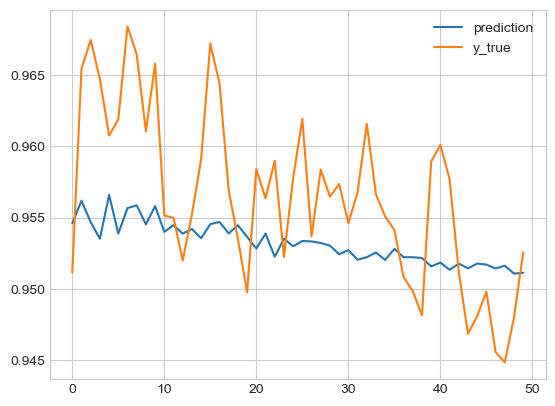

In [42]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('moving_average_predictions3.png', dpi = 300);

## 2. SSA

In [4]:
def optimize_function(trial):
    l = trial.suggest_int('window_length', 3,300)
    rank = trial.suggest_int('rank', 1, l)
    dim = trial.suggest_int('dim', 3,1000)

    ssa = SSA(l = l, rank = rank)
    smoothed_ts, _ = ssa.transform_to_series(ts_train)
    smoothed_ts = smoothed_ts.sum(0)

    mape_scores = []
    r2_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [ ]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('SSA_study3.csv')

[I 2024-05-18 11:57:42,897] A new study created in memory with name: no-name-4ce7d4db-9265-4aff-aa8f-4bb09c28b7f2


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-18 11:57:51,254] Trial 0 finished with values: [-1.2163209291759423, 0.0076288778112660076] and parameters: {'window_length': 272, 'rank': 126, 'dim': 207}. 
[I 2024-05-18 11:57:55,971] Trial 1 finished with values: [-1.0412253416174122, 0.007175349090814601] and parameters: {'window_length': 33, 'rank': 7, 'dim': 978}. 
[I 2024-05-18 11:58:03,333] Trial 2 finished with values: [-0.24971743127812918, 0.00586804617389131] and parameters: {'window_length': 242, 'rank': 94, 'dim': 238}. 
[I 2024-05-18 11:58:06,797] Trial 3 finished with values: [-1.5070952499156203, 0.007877847563460912] and parameters: {'window_length': 36, 'rank': 29, 'dim': 126}. 
[I 2024-05-18 11:58:17,892] Trial 4 finished with values: [-1.2810909271602948, 0.007604101019182702] and parameters: {'window_length': 297, 'rank': 132, 'dim': 790}. 
[I 2024-05-18 11:58:22,231] Trial 5 finished with values: [-0.5981350169895086, 0.006397690757407658] and parameters: {'window_length': 90, 'rank': 32, 'dim': 642}. 

In [6]:
study.best_trials[0].params

{'window_length': 61, 'rank': 30, 'dim': 905}

In [7]:
ssa = SSA(l = 61, rank = 30)
smoothed_ts, _ = ssa.transform_to_series(ts_train)
smoothed_ts = smoothed_ts.sum(0)

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=905)

R2: -0.2131749453243481
MAPE: 0.0055775802222151685
MSE: 4.40253028915971e-05


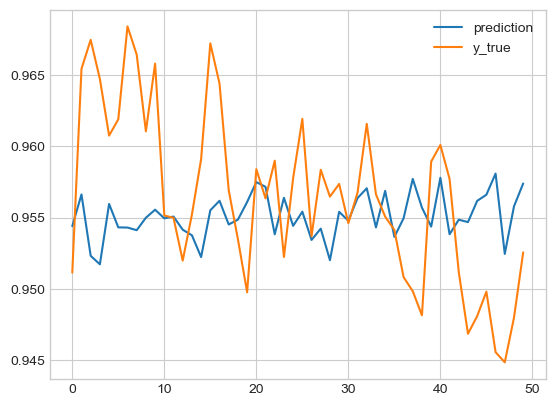

In [8]:
# предсказания
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('ssa_predictions3.png', dpi = 300);

## 3. Exponential smooting

In [9]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    dim = trial.suggest_int('dim', 3,1000)

    smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [10]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('Exp_smoothing_study3.csv')

[I 2024-05-18 14:18:19,294] A new study created in memory with name: no-name-035a962c-df6a-4dd7-b0da-2b4948af4480


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-18 14:18:23,583] Trial 0 finished with values: [-0.8157508699138099, 0.006769338266038705] and parameters: {'smoothing_level': 0.3806167664818264, 'dim': 904}. 
[I 2024-05-18 14:18:27,632] Trial 1 finished with values: [-0.34912979805959826, 0.005933903899396661] and parameters: {'smoothing_level': 0.5855621864660694, 'dim': 838}. 
[I 2024-05-18 14:18:29,988] Trial 2 finished with values: [-1.0605667758502864, 0.007134322161571421] and parameters: {'smoothing_level': 0.1817746338169799, 'dim': 503}. 
[I 2024-05-18 14:18:31,701] Trial 3 finished with values: [-0.5186648377333016, 0.0063063535209949865] and parameters: {'smoothing_level': 0.5855424515326731, 'dim': 262}. 
[I 2024-05-18 14:18:33,218] Trial 4 finished with values: [-0.3808560368882955, 0.005898779439765913] and parameters: {'smoothing_level': 0.4742136325432218, 'dim': 108}. 
[I 2024-05-18 14:18:36,135] Trial 5 finished with values: [-0.7135888612118448, 0.0066298527793391595] and parameters: {'smoothing_level':

In [11]:
study.best_trials[0].params

{'smoothing_level': 0.2272052575092658, 'dim': 244}

In [12]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothed_ts = SimpleExpSmoothing(ts_train).fit(smoothing_level, optimized = False).fittedvalues

model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, dim=244)

R2: -0.22201903639698828
MAPE: 0.005903379684217596
MSE: 4.434624900886937e-05


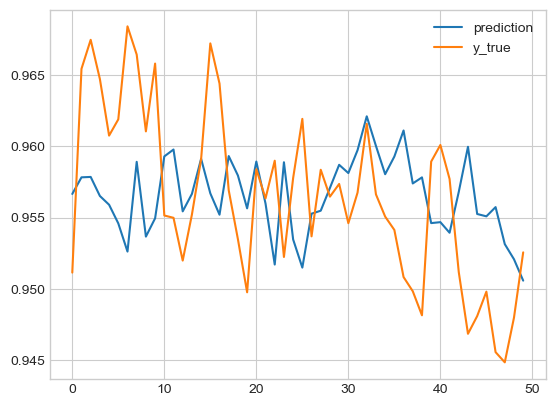

In [13]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('exp_smoothed_predictions3.png', dpi = 300);

## 4. Holt's model

In [14]:
def optimize_function(trial):
    smoothing_level = trial.suggest_float('smoothing_level', 0,1)
    smoothing_trend = trial.suggest_float('smoothing_trend', 0,1)
    # seasonal_periods = trial.suggest_categorical('seasonal_periods', [2,4,6,7,12,30])
    # seasonal = trial.suggest_categorical('seasonal', ['add', 'mul', 'additive', 'multiplicative', None])
    #use_boxcox = trial.suggest_categorical('use_boxcox', [True, False])
    dim = trial.suggest_int('dim', 3,1000)

    smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues

    r2_scores = []
    mape_scores = []
    for _ in range(5):
        model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
        r2, mape, _, _ = validate_model(model, smoothed_ts, ts_test, M, dim)
        r2_scores.append(r2)
        mape_scores.append(mape)

    return np.array(r2_scores).mean(), np.array(mape_scores).mean()

In [15]:
study = optuna.create_study(directions=["maximize", "minimize"])
study.optimize(optimize_function, n_trials=1000, show_progress_bar=True)

df = study.trials_dataframe()
df.to_csv('HoltWinters_study3.csv')

[I 2024-05-18 17:01:50,591] A new study created in memory with name: no-name-a28308bc-5291-4a11-9a15-657bcb13cc70


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-05-18 17:01:54,973] Trial 0 finished with values: [-0.3247016745364716, 0.005869712881086381] and parameters: {'smoothing_level': 0.9938158478075421, 'smoothing_trend': 0.14025622568840745, 'dim': 932}. 
[I 2024-05-18 17:01:56,706] Trial 1 finished with values: [-0.697254715867678, 0.006474453193321172] and parameters: {'smoothing_level': 0.5523342775336312, 'smoothing_trend': 0.2967159676093998, 'dim': 188}. 
[I 2024-05-18 17:02:00,808] Trial 2 finished with values: [-1.7795070870737022, 0.008395325535678348] and parameters: {'smoothing_level': 0.7152838931741237, 'smoothing_trend': 0.38915820469914, 'dim': 963}. 
[I 2024-05-18 17:02:02,085] Trial 3 finished with values: [-0.5175667463470173, 0.006194478947207467] and parameters: {'smoothing_level': 0.09193892345711163, 'smoothing_trend': 0.5870991179179087, 'dim': 9}. 
[I 2024-05-18 17:02:05,765] Trial 4 finished with values: [-1.1111119250769186, 0.007350348309201315] and parameters: {'smoothing_level': 0.36531728775607475, 

In [16]:
study.best_trials[0].params

{'smoothing_level': 0.0700636979466861,
 'smoothing_trend': 0.7232915514834799,
 'dim': 504}

In [17]:
smoothing_level = study.best_trials[0].params['smoothing_level']
smoothing_trend = study.best_trials[0].params['smoothing_trend']

smoothed_ts = ExponentialSmoothing(ts_train,  \
                               use_boxcox = False).fit(smoothing_level = \
                                                            smoothing_level, smoothing_trend = smoothing_trend,\
                                                            optimized = False).fittedvalues
model = MLPRegressor((20,20), activation = 'relu', solver = 'adam', learning_rate = 'constant', max_iter = 10**4)
r2, mape, mse, predictions = validate_model(model, smoothed_ts, ts_test, M, 11)

R2: -0.2461494349272273
MAPE: 0.005737699041229108
MSE: 4.5221924943558823e-05


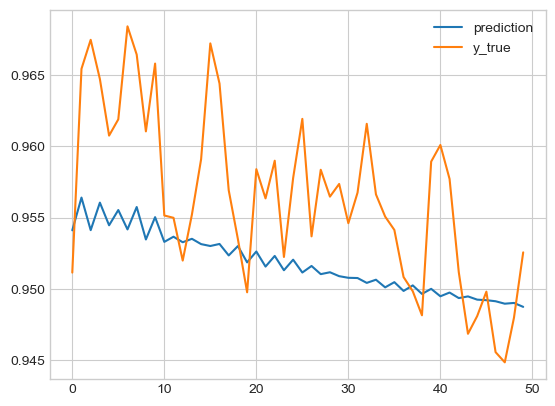

In [18]:
print('R2:', r2)
print('MAPE:', mape)
print('MSE:', mse)

sns.lineplot(x = np.arange(M), y = predictions[:,0], label = 'prediction')
sns.lineplot(x = np.arange(M), y = ts_test, label = 'y_true')
plt.savefig('holts_predictions3.png', dpi = 300);

# Сравнение ошибок

In [3]:
# первый датасет
mov_average = pd.read_csv('moving_average_study.csv')
ssa = pd.read_csv('SSA_study.csv')
exp_smoothing = pd.read_csv('Exp_smoothing_study.csv')
holt = pd.read_csv('HoltWinters_study.csv')

In [5]:
mov_average[mov_average['values_1'] == mov_average['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_window_length,system_attrs_nsga2:generation,state
304,304,304,-0.178585,0.101367,2024-05-10 16:56:53.953150,2024-05-10 16:56:55.453227,0 days 00:00:01.500077,3,164,6,COMPLETE


In [6]:
ssa[ssa['values_1'] == ssa['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_rank,params_window_length,system_attrs_nsga2:generation,state
450,450,450,0.700535,0.055433,2024-05-10 18:56:47.611587,2024-05-10 18:56:55.463579,0 days 00:00:07.851992,35,26,58,9,COMPLETE


In [8]:
exp_smoothing[exp_smoothing['values_1'] == exp_smoothing['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,system_attrs_nsga2:generation,state
145,145,145,0.601447,0.073181,2024-05-16 07:27:25.268314,2024-05-16 07:27:27.626739,0 days 00:00:02.358425,61,0.925067,2,COMPLETE


In [9]:
holt[holt['values_1'] == holt['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,params_smoothing_trend,params_use_boxcox,system_attrs_nsga2:generation,state
141,141,141,0.65362,0.066305,2024-05-16 08:23:25.390182,2024-05-16 08:23:29.627093,0 days 00:00:04.236911,52,0.896399,0.421892,False,2,COMPLETE


In [10]:
# второй датасет
mov_average = pd.read_csv('moving_average_study2.csv')
ssa = pd.read_csv('SSA_study2.csv')
exp_smoothing = pd.read_csv('Exp_smoothing_study2.csv')
holt = pd.read_csv('HoltWinters_study2.csv')

In [11]:
mov_average[mov_average['values_1'] == mov_average['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_window_length,system_attrs_nsga2:generation,state
780,780,780,-2.88849,0.000037,2024-05-16 13:00:33.140798,2024-05-16 13:00:35.352682,0 days 00:00:02.211884,8,19,15,COMPLETE


In [12]:
ssa[ssa['values_1'] == ssa['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_rank,params_window_length,system_attrs_nsga2:generation,state
569,569,569,-2.10963,0.000032,2024-05-16 14:28:02.217628,2024-05-16 14:28:04.708055,0 days 00:00:02.490427,6,9,77,11,COMPLETE


In [13]:
exp_smoothing[exp_smoothing['values_1'] == exp_smoothing['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,system_attrs_nsga2:generation,state
972,972,972,-2.558396,0.000034,2024-05-16 18:21:06.466570,2024-05-16 18:21:08.640821,0 days 00:00:02.174251,10,0.883497,19,COMPLETE


In [14]:
holt[holt['values_1'] == holt['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,params_smoothing_trend,system_attrs_nsga2:generation,state
496,496,496,-2.119104,0.000032,2024-05-18 08:33:54.462132,2024-05-18 08:33:56.703056,0 days 00:00:02.240924,11,0.357199,0.937886,9,COMPLETE


In [15]:
# третий датасет
mov_average = pd.read_csv('moving_average_study3.csv')
ssa = pd.read_csv('SSA_study3.csv')
exp_smoothing = pd.read_csv('Exp_smoothing_study3.csv')
holt = pd.read_csv('HoltWinters_study3.csv')

In [16]:
mov_average[mov_average['values_1'] == mov_average['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_window_length,system_attrs_nsga2:generation,state
878,878,878,-0.147962,0.005405,2024-05-18 11:15:20.207059,2024-05-18 11:15:21.868277,0 days 00:00:01.661218,28,102,17,COMPLETE


In [17]:
ssa[ssa['values_1'] == ssa['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_rank,params_window_length,system_attrs_nsga2:generation,state
992,992,992,-0.147263,0.005439,2024-05-18 13:53:24.781488,2024-05-18 13:53:31.424422,0 days 00:00:06.642934,905,30,61,19,COMPLETE


In [18]:
exp_smoothing[exp_smoothing['values_1'] == exp_smoothing['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,system_attrs_nsga2:generation,state
235,235,235,-0.077567,0.005245,2024-05-18 14:31:23.884370,2024-05-18 14:31:26.173283,0 days 00:00:02.288913,244,0.227205,4,COMPLETE


In [19]:
holt[holt['values_1'] == holt['values_1'].min()]

,Unnamed: 0,number,values_0,values_1,datetime_start,datetime_complete,duration,params_dim,params_smoothing_level,params_smoothing_trend,system_attrs_nsga2:generation,state
154,154,154,-0.072855,0.005326,2024-05-18 17:10:41.873481,2024-05-18 17:10:45.188570,0 days 00:00:03.315089,504,0.070064,0.723292,3,COMPLETE
